Buy Price: 8204.0, time: 2010-01-05T09:45:00.000000000
Sell Price: 8240.0, time: 2010-01-13T09:45:00.000000000
Trade completed

Buy Price: 8310.0, time: 2010-01-15T08:45:00.000000000
Sell Price: 8277.0, time: 2010-01-19T10:45:00.000000000
Trade completed

Buy Price: 7711.0, time: 2010-01-28T12:45:00.000000000
Sell Price: 7496.0, time: 2010-01-29T09:45:00.000000000
Trade completed

Buy Price: 7577.0, time: 2010-01-29T10:45:00.000000000
Sell Price: 7456.0, time: 2010-02-03T08:45:00.000000000
Trade completed

Buy Price: 7505.0, time: 2010-02-03T09:45:00.000000000
Sell Price: 7232.0, time: 2010-02-05T10:45:00.000000000
Trade completed

Buy Price: 7163.0, time: 2010-02-08T12:45:00.000000000
Sell Price: 7574.0, time: 2010-02-22T12:45:00.000000000
Trade completed

Buy Price: 7479.0, time: 2010-02-23T09:45:00.000000000
Sell Price: 7347.0, time: 2010-02-25T12:45:00.000000000
Trade completed

Buy Price: 7553.0, time: 2010-03-01T10:45:00.000000000
Sell Price: 7509.0, time: 2010-03-04T12:45:00.000

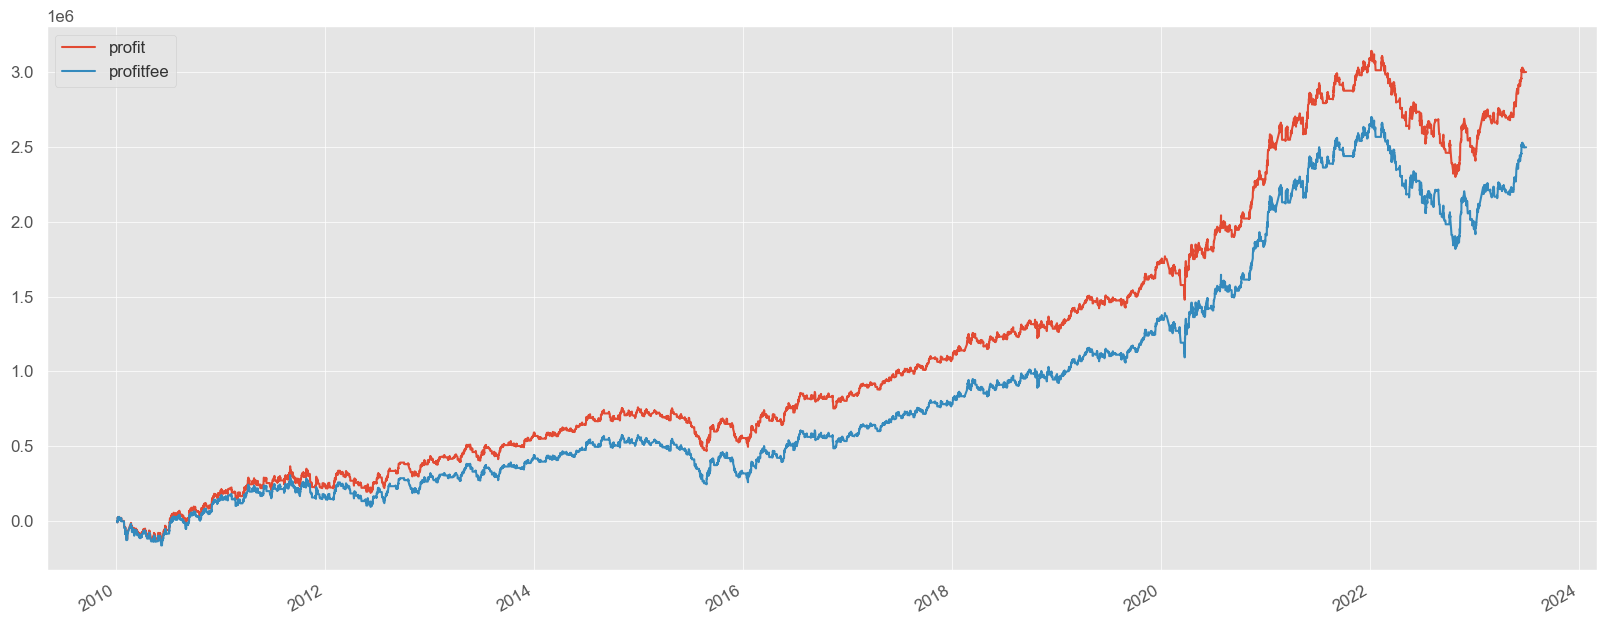

Profit :  2497200.0
Return :  2.4972
Max DrawDown :  0.2383912643926699
Caimar Ratio :  10.475216054421768
Trade Times :  419
Win Rate :  0.4224343675417661
Profit Factor :  1.4388443694643611


In [1]:
#### 進場 (ＭＡＣＤ > Signal) 
#### 出場 (ＭＡＣＤ < Signal)＋ (ＲＳＩ< 50)


### 做多

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import quantstats
import os


plt.style.use('ggplot')
pd.set_option('display.max_rows', None)


###樣本內資料

## 獨台指期 1 分K
df= pd.read_csv('TWF_Futures_Minute_Trade.txt')

## 整理資料
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time']) ## 中間要加空格 pandas 的用法
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df = df.drop(columns=['volume'])
df['Hour'] = df.index.map(lambda x: x.hour)

## 只抓日盤 =>時間只在8~13點之間
rule = '60T' ##以1個小時為單位

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']] #只要 open 的第一個值
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]


df_Morning = pd.concat([d1,d2,d3,d4], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)

## 只抓夜盤 =>時間不能是8~13點之間
rule = '60T'

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
#d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4], axis=1)
df_Night = df_Night.dropna()

## 完整資料: 日盤 + 夜盤
df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)

## 選擇回測資料
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)




###樣本外資料

# 讀取 CSV 文件
df_o = pd.read_csv('TXF_樣本外.csv')

# 設置列名
df_o.columns = ['datetime', 'open', 'high', 'low', 'close']

# 將日期時間欄位轉換為索引
df_o['datetime'] = pd.to_datetime(df_o['datetime'])
df_o.set_index('datetime', inplace=True)

# 新增 Hour 欄位
df_o['Hour'] = df_o.index.hour

## 只抓日盤 =>時間只在8~13點之間
rule = '60T' ##以1個小時為單位

Morning_o = df_o[(df_o['Hour'] >= 8) & (df_o['Hour'] <= 13)]
Morning_o.index = Morning_o.index + dt.timedelta(minutes=15)

d1_o = Morning_o.resample(rule=rule, closed='right', label='left').first()[['open']] #只要 open 的第一個值
d2_o = Morning_o.resample(rule=rule, closed='right', label='left').max()[['high']]
d3_o = Morning_o.resample(rule=rule, closed='right', label='left').min()[['low']]
d4_o = Morning_o.resample(rule=rule, closed='right', label='left').last()[['close']]


df_Morning_o = pd.concat([d1_o,d2_o,d3_o,d4_o], axis=1)
df_Morning_o = df_Morning_o.dropna()
df_Morning_o.index = df_Morning_o.index - dt.timedelta(minutes=15)

## 只抓夜盤 =>時間不能是8~13點之間
rule = '60T'

Night_o = df_o[(df_o['Hour'] < 8) | (df_o['Hour'] > 13)]

d1_o = Night_o.resample(rule=rule, closed='right', label='left').first()[['open']]
d2_o = Night_o.resample(rule=rule, closed='right', label='left').max()[['high']]
d3_o = Night_o.resample(rule=rule, closed='right', label='left').min()[['low']]
d4_o = Night_o.resample(rule=rule, closed='right', label='left').last()[['close']]


df_Night_o = pd.concat([d1_o,d2_o,d3_o,d4_o], axis=1)
df_Night_o = df_Night_o.dropna()

## 完整資料: 日盤 + 夜盤
df_Day_o = pd.concat([df_Morning_o, df_Night_o], axis=0)
df_Day_o = df_Day_o.sort_index(ascending=True)

## 選擇回測資料
df_Morning_o['Hour'] = df_Morning_o.index.map(lambda x: x.hour)



#合併樣本內/外資料
trainData = df_Morning[(df_Morning.index >= '2010-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()  # trend data
testData = df_Morning_o[(df_Morning_o.index >= '2020-1-1 00:00:00') & (df_Morning_o.index <= '2023-6-30 00:00:00')].copy() # test data

fullData = pd.concat([trainData,testData])



## 取得結算日期
settlementDate_ = pd.read_csv('settlement_date.csv', encoding = 'cp1252')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']

#只抓取資料沒有 "W" 的(因為 W 代表周結算)
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

## 回測假設
# 換月轉倉：結算日當天直接平倉
# 進場限制：結算日當天不進場
# 報酬計算：200 * 點數
# 手續費+滑價：單邊 600元

#參數設定
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.04


#MACD
fullData['EMA25'] = fullData['close'].ewm(span=25, adjust=False).mean()
fullData['EMA45'] = fullData['close'].ewm(span=45, adjust=False).mean()
fullData['MACD'] = fullData['EMA25'] - fullData['EMA45']
fullData['Signal'] = fullData['MACD'].ewm(span=6, adjust=False).mean()

# RSI函數
def rsi(df, periods , ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

fullData['RSI']=rsi(fullData, periods = 22, ema = True)


#將時間序列數據轉換為NumPy數組
df_arr = np.array(fullData)
time_arr = np.array(fullData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]


#建立存放資料的單位
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

#開始交易流程
for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 選擇 MACD 突破 Signal 且 RSI > 50
    entryLong =  df_arr[i,7] > df_arr[i,8] 
    ### 結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### MACD 跌破 Signal
    exitShort = df_arr[i,7] < df_arr[i,8] and df_arr[i,9] < 50

    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,4] >= 11

    #做多的狀態
    if BS == 'B':
      # 停損條件
      #以達成進場條件當作關鍵 K 棒，並設其最低點為停損點
      stopLoss  = df_arr[i,3] <= df_arr[t,2] 

    #還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        #確認進場&相關設定
        if entryLong and entryCondition:
            #更改狀態至做多
            BS = 'B'
            #紀錄進場時間
            t = i+1
            buy.append(t)
            print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    #進場開始計算未實現損益
    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        #近場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition  :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)

            #紀錄出場時間
            sell.append(i+1)

            #重置交易狀態
            BS = None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()


            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        #出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=fullData.index)
# print(equity)
equity.plot(grid=True, figsize=(20,8))
plt.show()

equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy) 
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)



Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023],
      dtype='int32')


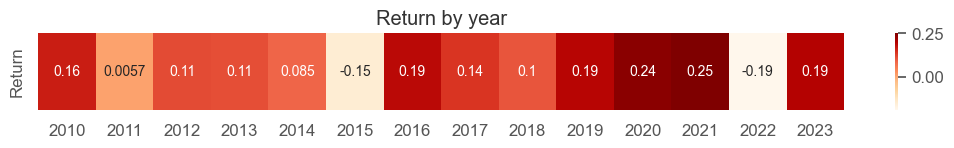

In [2]:
# 時間損益(年)
equity.index = pd.to_datetime(equity.index) #確保索引是datetime型態


years = ['2010','2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020','2021','2022','2023']
year_ret = []
print(equity.index.year.unique())


for year in years:
    year_data = equity[ equity.index.year == int(year) ]
    if len(year_data) > 0:
        year_return = (year_data['equity'].iloc[-1] / year_data['equity'].iloc[0]) - 1
        year_ret.append(year_return)

df = pd.DataFrame({'Return':year_ret},index = years)

# heatmap函式
plt.figure(figsize=(13,1))
sns.heatmap(df.transpose(), annot=True, cmap='OrRd')
plt.title('Return by year')
plt.show()
print('')

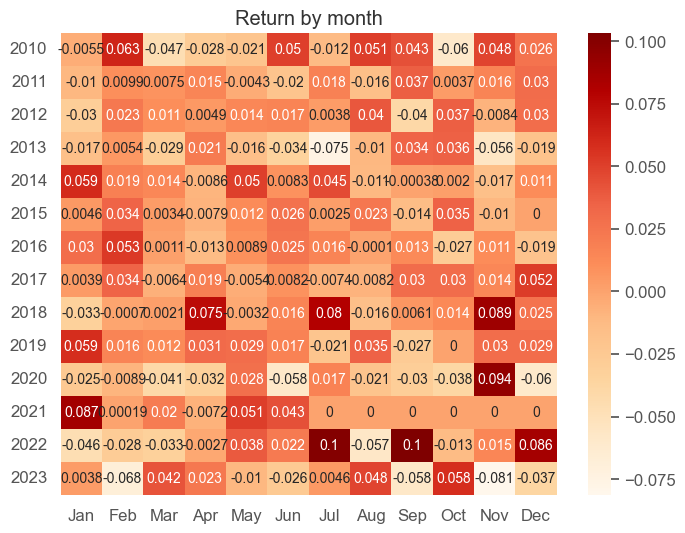

In [3]:
# 時間損益(月)
group_data = equity.groupby([equity.index.year, equity.index.month])

# 初始化一個 12x12 的矩陣來儲存損益率數據
month_ret = np.zeros((14, 12))

for group, data in group_data:
    year_index = group[0] - 2012  # 計算年份在矩陣中的索引位置
    month_index = group[1] - 1     # 計算月份在矩陣中的索引位置
    month_ret[year_index, month_index] = data['equity'].iloc[-1] / data['equity'].iloc[0] - 1

# 將矩陣轉換為 DataFrame
df = pd.DataFrame(month_ret, columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                  index=years)

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='OrRd')
plt.title('Return by month')
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2010-01-04
End Period                 2023-06-29
Risk-Free Rate             0.0%
Time in Market             60.0%

Cumulative Return          249.72%
CAGR﹪                     6.62%

Sharpe                     0.35
Prob. Sharpe Ratio         99.75%
Smart Sharpe               0.33
Sortino                    0.5
Smart Sortino              0.48
Sortino/√2                 0.35
Smart Sortino/√2           0.34
Omega                      1.09

Max Drawdown               -23.84%
Longest DD Days            619
Volatility (ann.)          6.06%
Calmar                     0.28
Skew                       0.21
Kurtosis                   26.44

Expected Daily %           0.01%
Expected Monthly %         0.78%
Expected Yearly %          9.35%
Kelly Criterion            4.47%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.62%
Expected Shortfall (cVaR)  -0.62%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-05,2022-10-25,2023-06-29,541,-23.839126,-22.812044
2,2014-11-04,2015-08-26,2016-07-15,619,-20.846574,-20.274565
3,2010-01-11,2010-06-07,2010-07-20,191,-18.528610,-17.263527
4,2011-09-01,2012-06-08,2013-01-02,489,-16.189309,-15.193751
5,2020-01-14,2020-03-23,2020-04-08,86,-12.395380,-10.964178


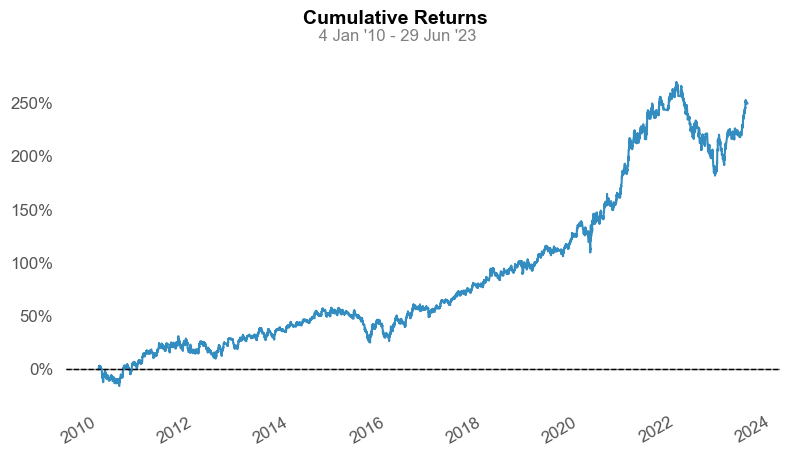

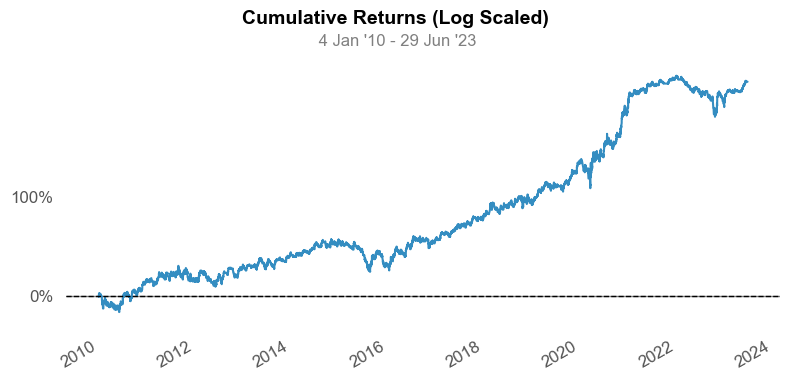

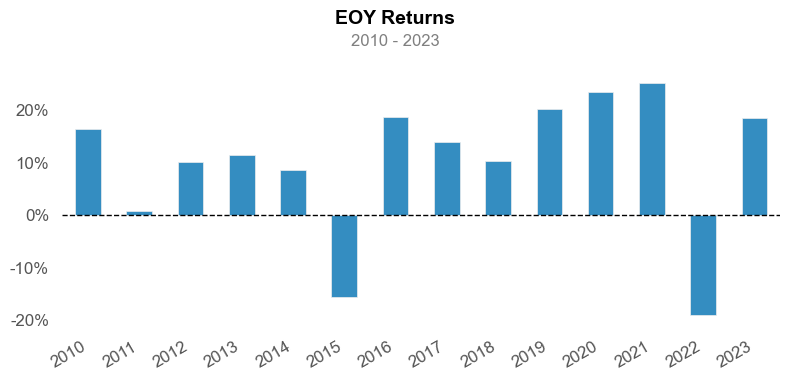

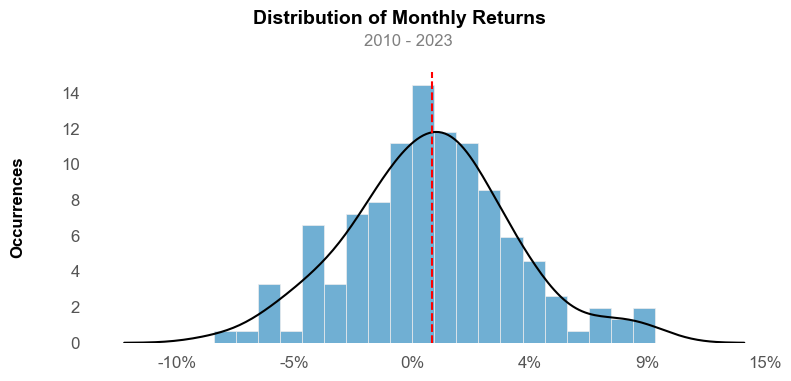

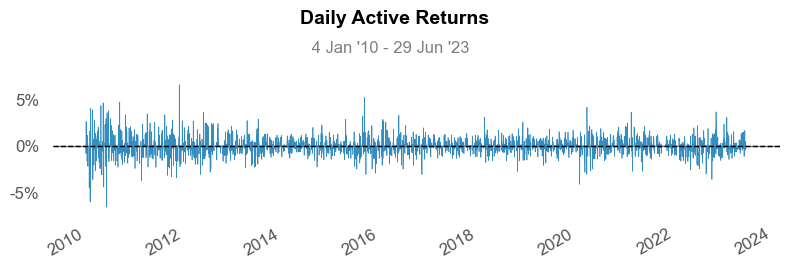

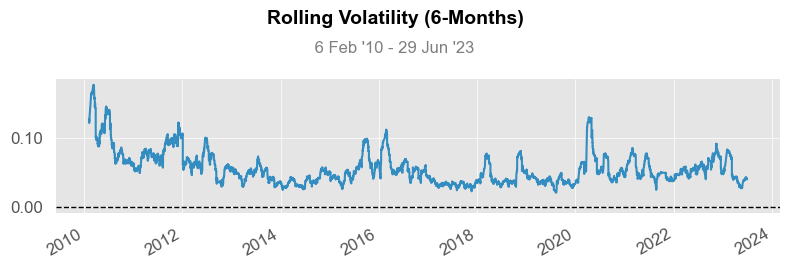

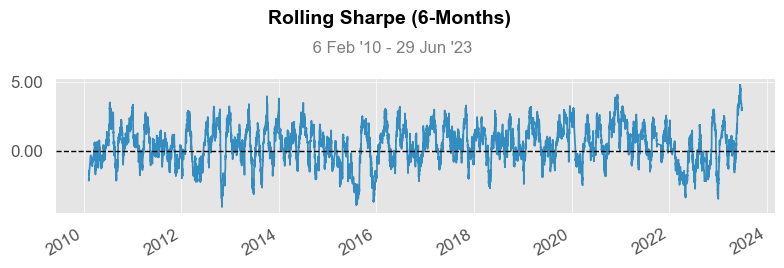

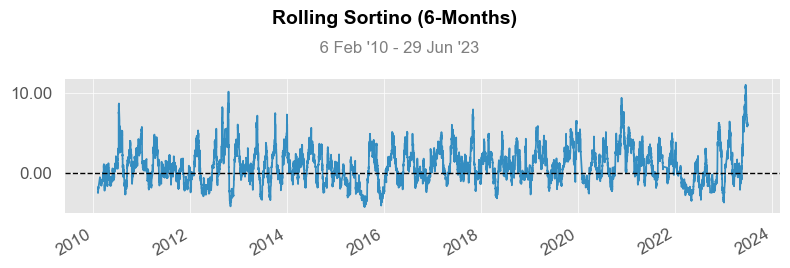

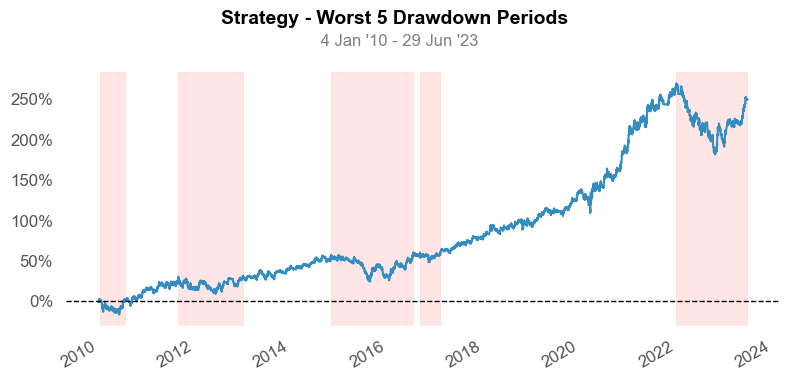

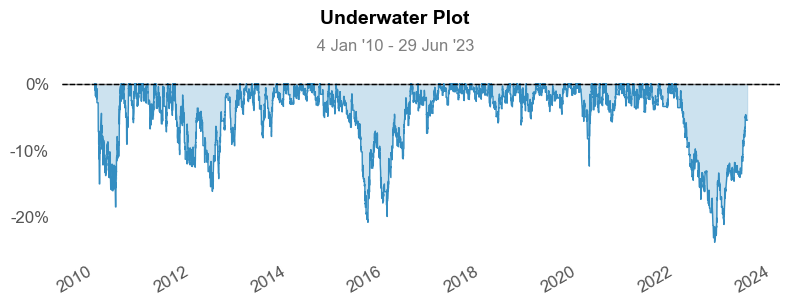

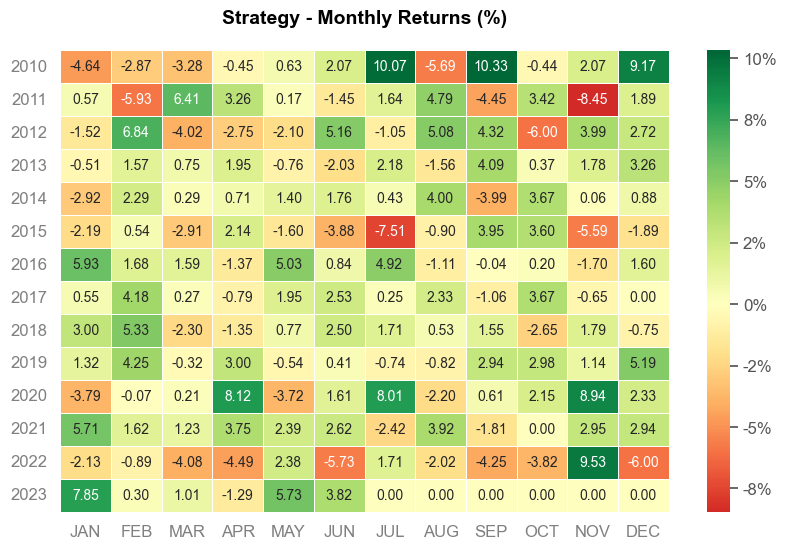

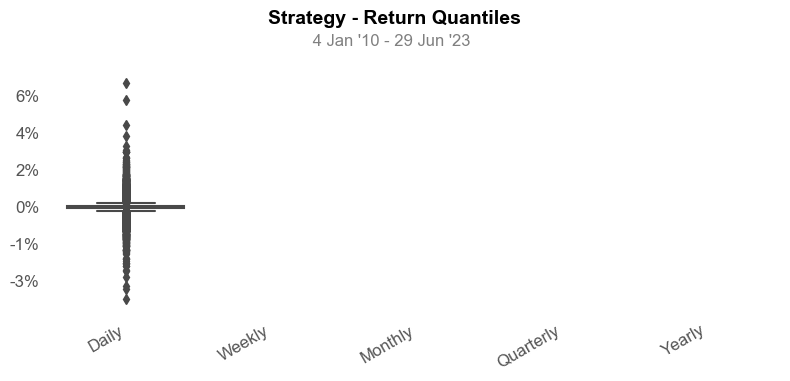

In [4]:
ret = equity['equity'].pct_change(periods=1).dropna()
#print(ret)
quantstats.reports.full(ret)